# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

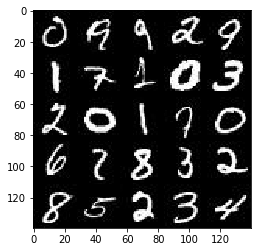

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

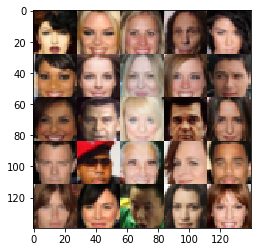

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
            return tf.maximum(x, alpha * x, name=name)
    
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    stddev = 0.02
    
    with tf.variable_scope('discriminator', reuse=reuse):

        x = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x = leaky_relu(x)
        
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x = tf.layers.batch_normalization(x, training=True)
        x = leaky_relu(x)
       
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x = tf.layers.batch_normalization(x, training=True)
        x = leaky_relu(x)
                
        x = tf.reshape(x, (-1, 4*4*128))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train):

        stddev = 0.02
        
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev) )
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim) 
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    batch_counter = 0
    show_every = 5
    num_images = 25
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                images = batch_images*2.0
                
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: images,input_z: sample_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, lr: learning_rate})
                                
                batch_counter += 1

                if (batch_counter % show_every == 0):
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                if (batch_counter % 50 == 0):
                    show_generator_output(sess, num_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 1.8957... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 1.9575
Epoch 1/2... Discriminator Loss: 2.7719... Generator Loss: 0.1649
Epoch 1/2... Discriminator Loss: 1.6787... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.3818
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.5615


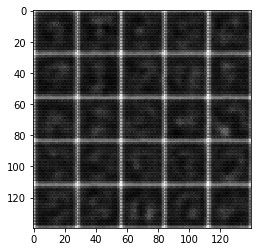

Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 1.5729... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 1.0595
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.0313
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.9199


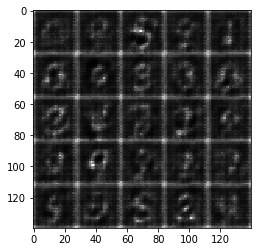

Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.8795
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 1.1474
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 1.3429
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.9358


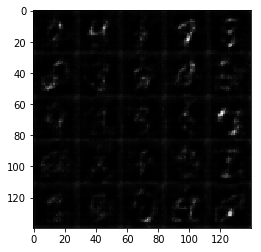

Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.3215
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 2.0198
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.5765


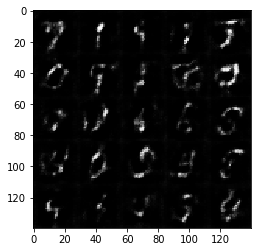

Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.0241... Generator Loss: 1.6990
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.2233
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.3681
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 1.3345
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 1.2292
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 1.3814


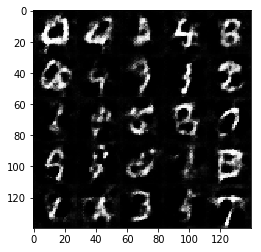

Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 0.6623
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 1.6509
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 0.3274


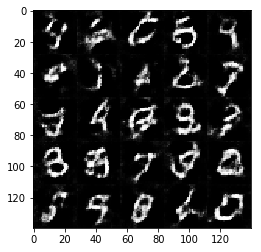

Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.2275
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.5358
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.0687
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 1.4903


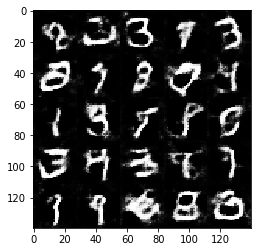

Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.2674
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 1.2189
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 1.1358
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 1.2106
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.6970


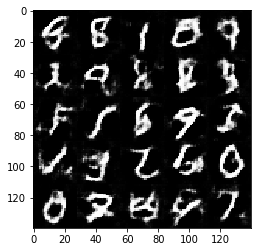

Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.5661
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.7169


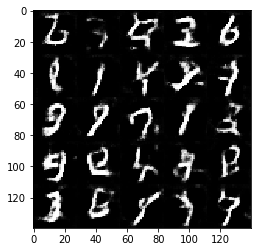

Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.2192
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 1.1359
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 1.1563
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.7190
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.1942
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.7125


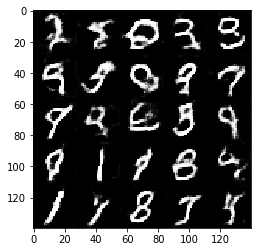

Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 1.4739
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 1.2520
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.7365


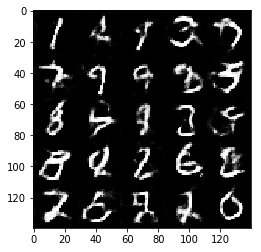

Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 1.2514
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 1.6384
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 1.5076
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 0.8902


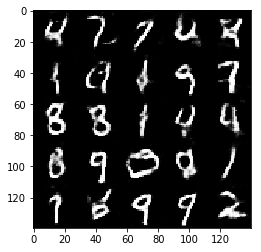

Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 1.4671
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.5711


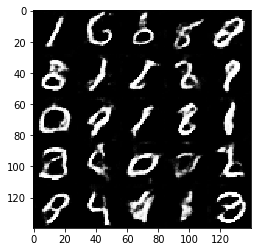

Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 1.6819
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.5293
Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 1.6534
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.9159


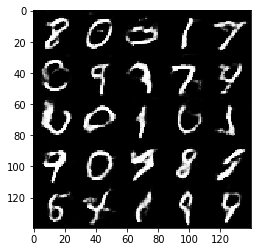

Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.4185
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 1.5508
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.9244
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 1.7334
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 1.1763


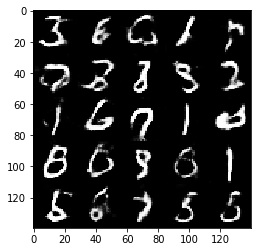

Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.2546
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.4357
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.5453


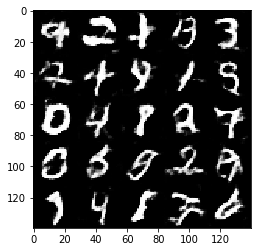

Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 1.8488... Generator Loss: 2.3617
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 1.1073
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 1.0156
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.5935


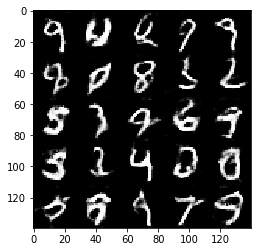

Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 1.1975
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 1.0517
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 1.0020


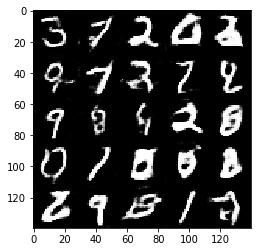

Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 1.2027
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 1.4541
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 1.1955


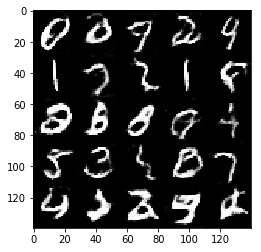

Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 1.5887
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 0.9706
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.7618


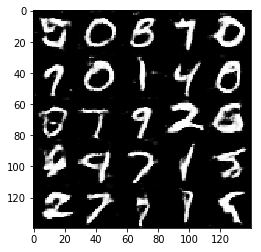

Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 1.6165
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 1.0646... Generator Loss: 1.2597
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 0.4631
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.3982
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.4982


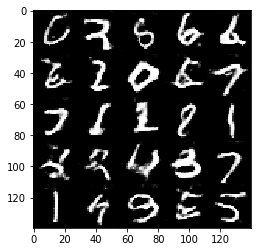

Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.1093
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.2669
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.1104
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.5524... Generator Loss: 0.4298


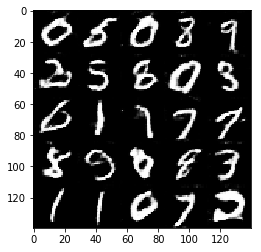

Epoch 2/2... Discriminator Loss: 1.2220... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.8290


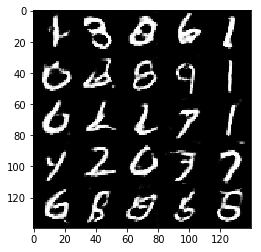

Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.5214
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 1.8051
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 2.2807
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 1.3138
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.5351
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.5697


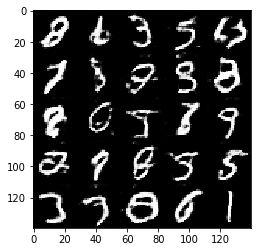

Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.6728... Generator Loss: 0.3535
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.9540
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 1.1677... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 0.7469


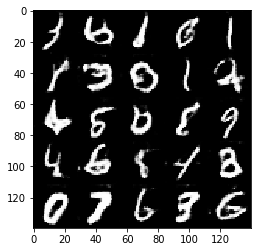

Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.0757... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.4869
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 1.5213
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.0201
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.1000
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 1.6241
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.4685
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.2901


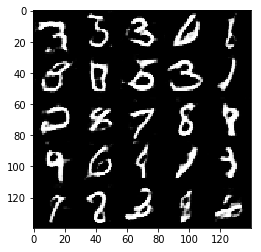

Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.4332
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 1.8023
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.5210... Generator Loss: 2.4604


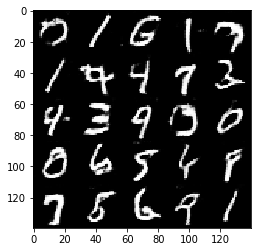

Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.6634
Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 1.0581
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 1.4483... Generator Loss: 0.5003
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 1.1047
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.0027
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 2.0787
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.8898


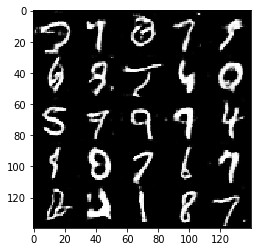

Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 1.6414... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.5533
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.7002


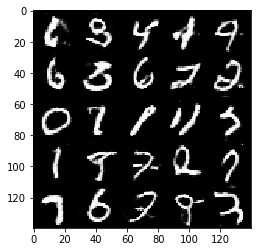

Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 0.8566... Generator Loss: 1.4629
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 1.5899
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 2.1734
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.6116


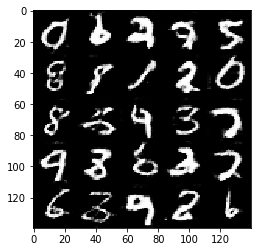

Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.4898... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 1.0111
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.0497


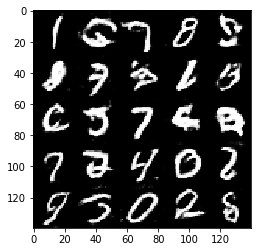

Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 1.9510
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 1.6116
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.6296
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 1.4460
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 0.8266


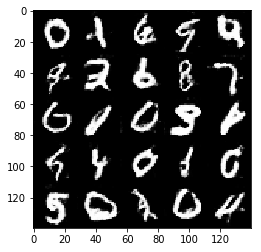

Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 1.1984
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 0.9479
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 1.3713
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 1.1209... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 1.4399... Generator Loss: 0.4855
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.6537


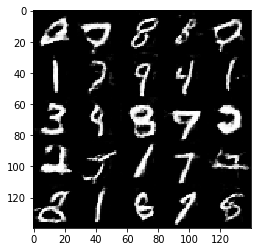

Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.1893
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 1.6258
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 1.8762
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.1017
Epoch 2/2... Discriminator Loss: 0.9521... Generator Loss: 1.5808


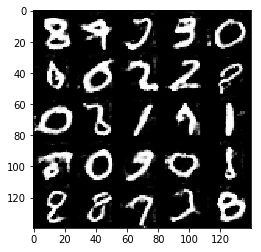

Epoch 2/2... Discriminator Loss: 0.9491... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.0144
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.4728
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 2.2673... Generator Loss: 3.3424
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 1.7330


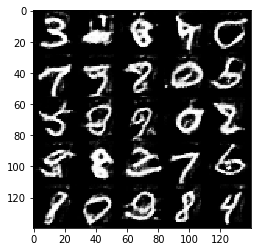

Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 1.5292
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.9840
Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.2944
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.4236
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.8098


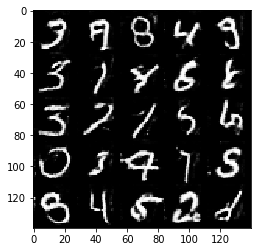

Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.9039
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.4496
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 1.0112
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.3169
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.7596


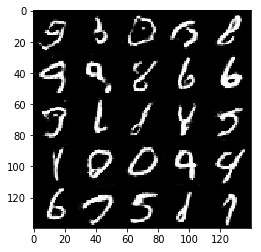

Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 1.5517... Generator Loss: 2.5971
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.3308
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 1.1005


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 2.0224
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 2.5602


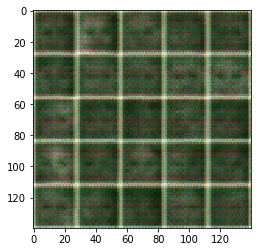

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.5836
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 2.1569
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 2.3530... Generator Loss: 4.5008


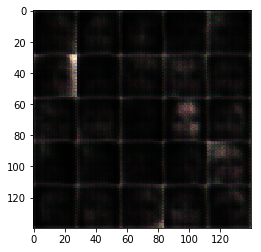

Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 3.6191
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.7708
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.9638


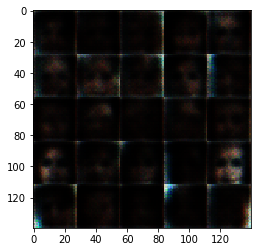

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.9587... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.7539... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.5244
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.3813


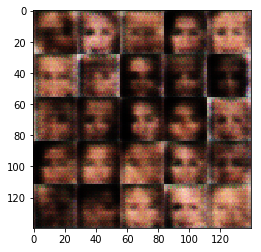

Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 2.1496
Epoch 1/1... Discriminator Loss: 1.8468... Generator Loss: 0.3114


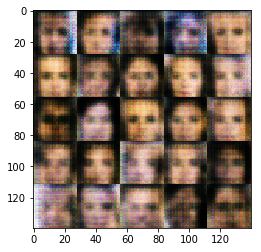

Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 1.7659
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.1467


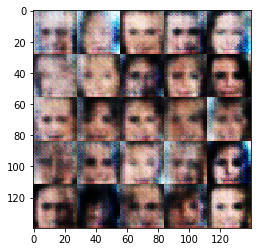

Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.9487
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.9631


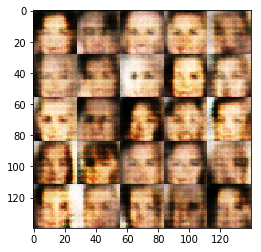

Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7802


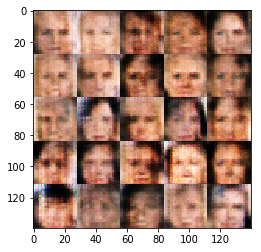

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.8152... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7741


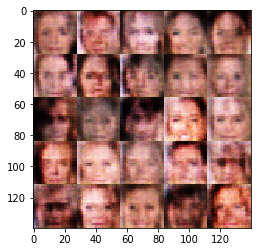

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6847


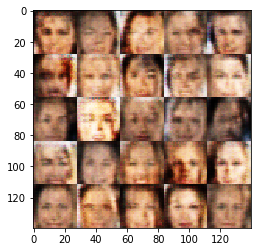

Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8257


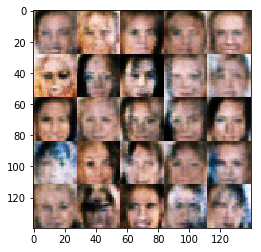

Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9719


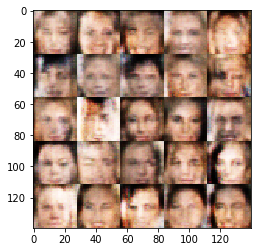

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8143


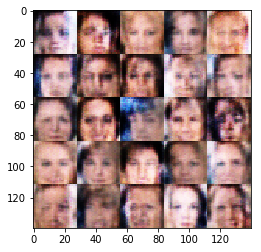

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8404


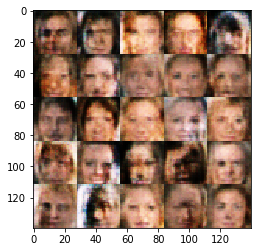

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8968


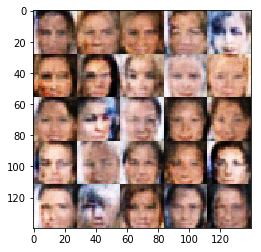

Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.9380


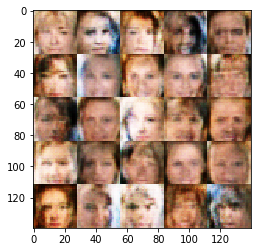

Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6396


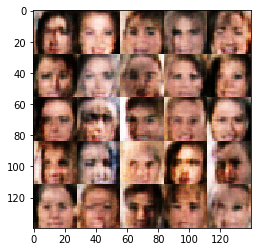

Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7698


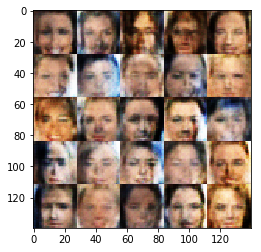

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.9270


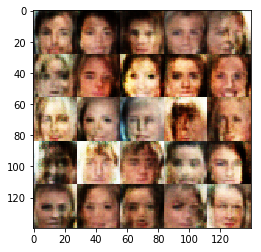

Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 1.0981


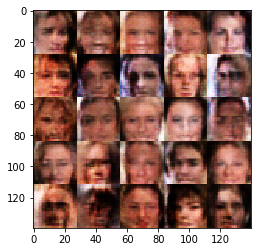

Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8591


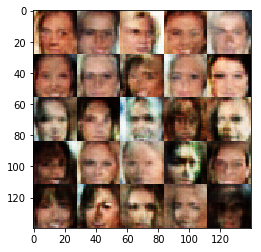

Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.5345


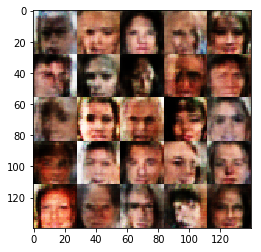

Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7978


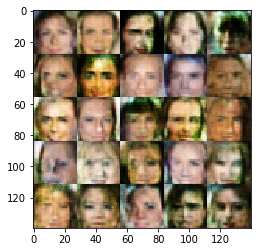

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.5566


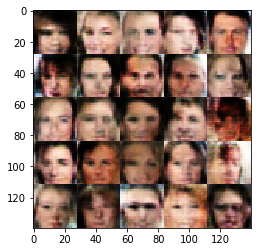

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.9772


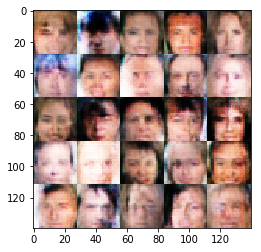

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6850


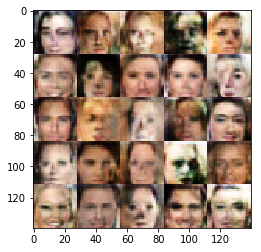

Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9411


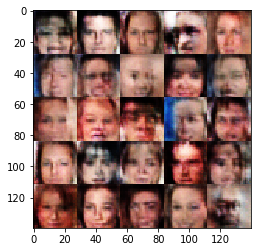

Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7279


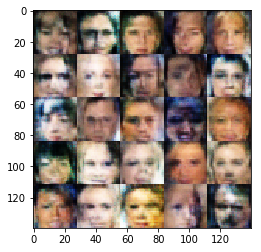

Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7931


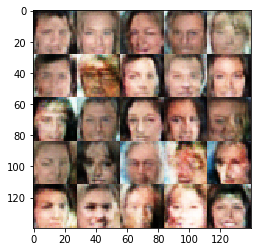

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7865


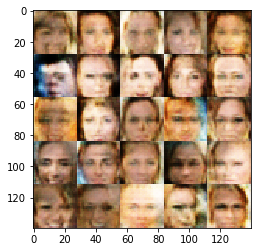

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7911


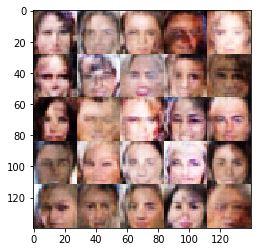

Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7522


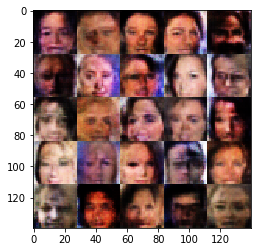

Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7507


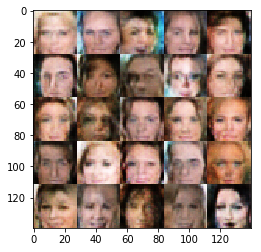

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6776


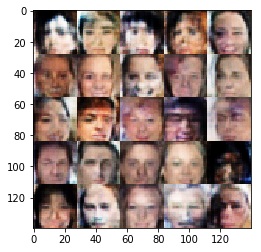

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.3338


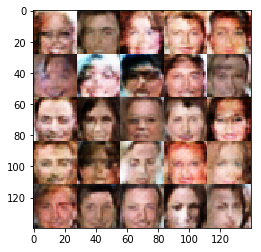

Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5590


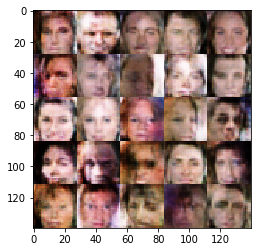

Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8558


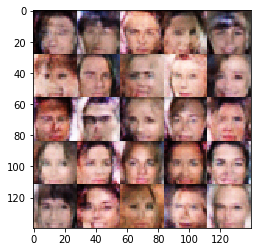

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.9279


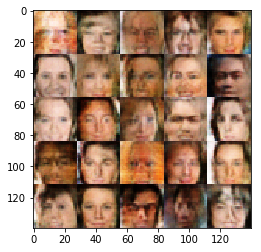

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6648


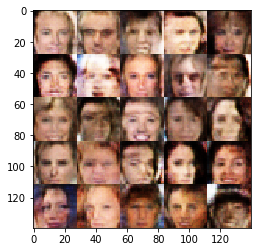

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7787


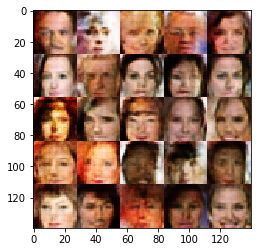

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8536


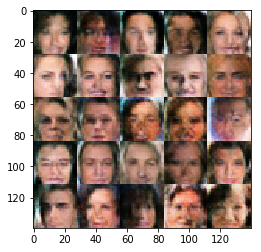

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8164


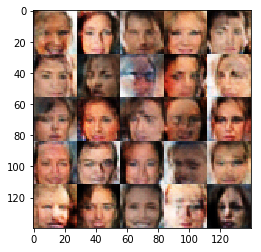

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.9844


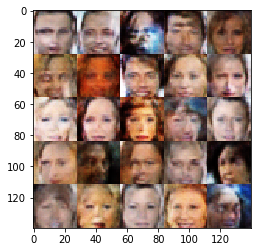

Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8591


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.